In [ ]:
import cv2
from keras.callbacks import *
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.utils import to_categorical
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
def read_img(file_name, color_inv_norm=True):
    """
    read a image from local file system
    :param file_name:
    :param color_inv_norm:
    :return:
    """
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

    if color_inv_norm:
        img = 255 - img

        # img = remove_back(img, np.ones((5, 5), np.uint8))

        img = img / 255.0
    else:
        img[img < 50] = 0
        img = img / 255.0

    return img

In [ ]:
def get_data(base_path):
    """

    :param base_path:
    :return:
    """
    nums = os.listdir(base_path)
    train_data = []
    train_label = []
    lbl = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
    for num in tqdm(nums):
        calc = 0
        jpgs = os.listdir(os.path.join(base_path, num))
#         print('-' * 30, 'now load %s' % num, '-' * 30)
        for jpg in jpgs:
            # calc += 1
            # if calc > 5000:
            #     print('the %s data is more than 5000' % num)
                # break

            fname = os.path.join(base_path, num, jpg)
            pic = read_img(fname, color_inv_norm=False)
            train_data.append(pic)
            train_label.append(lbl[int(num)])

    train_data = np.array(train_data)
    train_label = np.array(train_label)
    # print(train_data.shape, train_label.shape)
    # print(train_data)
    # print(np.argmax(train_label, axis=1))
    return train_data, train_label

In [ ]:
X, y = get_data('/Users/imperatore/tmp/num_ocr')
X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train.shape, y_train.shape

# Model

In [ ]:
num_class = 10
input_tensor = Input((48, 48, 1))

In [ ]:
def vgg(input_tensor):
    vgg = VGG16(include_top=False, input_tensor=input_tensor)
    return vgg

In [ ]:
# def resnet_pretrain(input_tensor):
#     rn = ResNet50(include_top=False, input_tensor=input_tensor)
#     return rn

def resnet(input_tensor, units=32, kernel_size=(3, 3)):
    x = input_tensor
    for i in range(2):
        x  =res_block(x, (2 ** i) * units, kernel_size=kernel_size)
    return x

In [ ]:
def conv2d_bn(x, units, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(units, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    return x

In [ ]:
def res_block(inpt, units, kernel_size, strides=(1, 1), with_conv_shortcut=True):
    x = conv2d_bn(inpt, units=units, kernel_size=kernel_size, strides=strides, padding='same')
    x = conv2d_bn(x, units=units, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = conv2d_bn(inpt, units=units, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

In [ ]:
def ordinary(x, ite=2):
    for i in range(ite):
        x = Conv2D(32 * 2 ** i, (3, 3), kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(32 * 2 ** 2, (3, 3), kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
    return x

In [ ]:
# x = ordinary(input_tensor)
x = resnet(input_tensor, units=32, kernel_size=(3,3))

x = Flatten()(x)
x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Dense(10, kernel_initializer='he_normal', activation='softmax')(x)
# print('now x\'s shape:', x.shape)

base_model = Model(input=input_tensor, output=x)
modellabels = Input(name='labels', shape=[num_class], dtype='float32')
model = Model(inputs=input_tensor, outputs=x)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
def get_non0_index_scope(l):
    """

    :param l:
    :return:
    """
    if l[0]:
        start = 0
    else:
        start = l.index(True)
    l.reverse()
    if l[0]:
        end = 0
    else:
        end = l.index(True)
    end = len(l) - end
    return start, end


def get_min_content_area(img):
    """

    :param img:
    :return:
    """
    col_proj = (np.sum(img, axis=0) != 0).tolist()
    row_proj = (np.sum(img, axis=1) != 0).tolist()
    col_start, col_end = get_non0_index_scope(col_proj)
    row_start, row_end = get_non0_index_scope(row_proj)

    return row_start, row_end, col_start, col_end


def get_resize_padding_img(img, size=None, padding=None):
    """

    :param img:
    :param size:
    :param padding:
    :return:
    """
    if size and padding:
        sub_img = cv2.resize(img, size)
        sub_img = np.pad(sub_img, padding, mode='constant')
        sub_img = np.pad(sub_img, ((3,), (3,)), mode='constant')
    else:
        sub_img = cv2.resize(img, (28, 28))
    return sub_img

In [ ]:
def preprocessing(img):
    row_start, row_end, col_start, col_end = get_min_content_area(img)
    sub_img = img[row_start: row_end, col_start: col_end]
    
    if col_end - col_start < row_end - row_start:  # 铅直边较长
        change_rate = (row_end - row_start - 42) / float((row_end - row_start))
        changed_width = int((col_end - col_start) * (1 - change_rate))

        if changed_width % 2 == 1:
            changed_width += 1
        if changed_width == 0:
            changed_width = 2
        pad = (42 - changed_width) / 2
        padding = ((0,), (int(pad),))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_width, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(changed_width, 42), padding=padding)

    else:  # 水平边较长
        # change_rate = (x1 - x0 - 42) / float((x1 - x0))
        # changed_height = int((y1 - y0) * (1 - change_rate))

        change_rate = (col_end - col_start - 42) / float((col_end - col_start))
        changed_height = int((row_end - row_start) * (1 - change_rate))

        if changed_height % 2 == 1:
            changed_height += 1
        if changed_height == 0:
            changed_height = 2
        pad = (42 - changed_height) / 2
        padding = ((int(pad),), (0,))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_height, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(42, changed_height), padding=padding)

    return sub_img

In [115]:
from keras.models import *
model = load_model('cnn3_gen.h5')

In [ ]:
np.mean(np.argmax(model.predict(X_test[:100]), axis=1) == np.argmax(y_test[:100], axis=1))

In [ ]:
np.mean(np.argmax(model.predict(X_test[:1000]), axis=1) == np.argmax(y_test[:1000], axis=1))

## CNN3

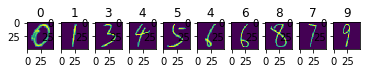

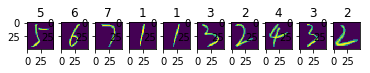

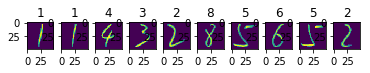

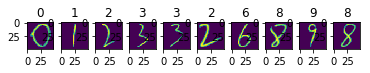

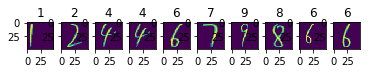

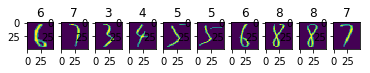

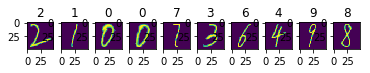

In [258]:
import matplotlib.pyplot as plt
for j in range(0, 7):
    
    for i in range(1, 11):
        img = cv2.imread('testimg/%s/%s.jpg' % (j, i), cv2.IMREAD_GRAYSCALE)
#         img = (255 - img) / 255.0
        img = 255 - img
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img[img < 0.16] = 0.0
        img[img > 0] += 0.2
        img[img > 1.] = 1.
        sub_img = preprocessing(img)

        plt.subplot(7, 10, i + j * 10)
        plt.imshow(sub_img)
        plt.title(np.argmax(nmodel.predict(np.expand_dims(np.expand_dims(sub_img, 0), -1))))
    plt.show()

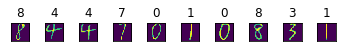

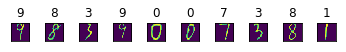

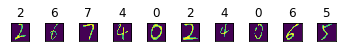

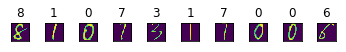

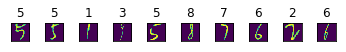

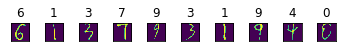

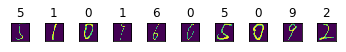

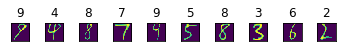

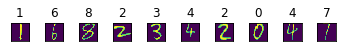

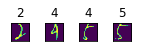

In [259]:
import os
j = 1
for i in os.listdir('F:/nums'):
    
    img = cv2.imread(os.path.join('F:/nums', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.3] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(10, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(nmodel.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

---

## CNN4

In [ ]:
from keras.models import *
model = load_model('cnn4_gen.h5')

In [ ]:
import matplotlib.pyplot as plt
for j in range(0, 7):
    
    for i in range(1, 11):
        img = cv2.imread('testimg/%s/%s.jpg' % (j, i), cv2.IMREAD_GRAYSCALE)
#         img = (255 - img) / 255.0
        img = 255 - img
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img[img < 0.3] = 0.0
        img[img > 0] += 0.2
        img[img > 1.] = 1.
        sub_img = preprocessing(img)

        plt.subplot(7, 10, i + j * 10)
        plt.imshow(sub_img)
        plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, 0), -1))))
    plt.show()

In [ ]:
import os
j = 1
for i in os.listdir('F:/nums'):
    
    img = cv2.imread(os.path.join('F:/nums', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.3] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(10, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

---

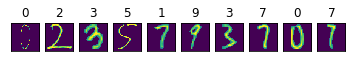

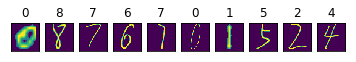

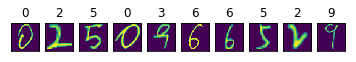

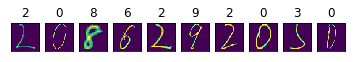

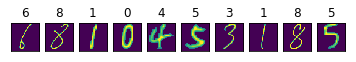

In [260]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\done')
l0 = l[: 50]
l1 = l[50: 100]
l2 = l[100: 150]
l3 = l[150: 200]
l4 = l[200: 250]
l5 = l[250: ]
for i in l0:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
j = 1
for i in l1:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
j = 1
for i in l2:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
j = 1
for i in l3:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
j = 1
for i in l4:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
j = 1
for i in l5:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(6, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\new')

for i in l:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\new', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\new')

for i in l:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\new', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\new')

for i in l:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\new', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(6, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\new')

for i in l:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\new', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(6, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

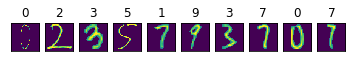

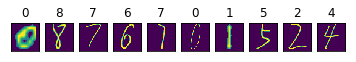

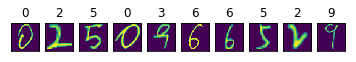

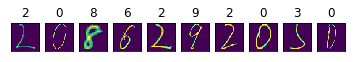

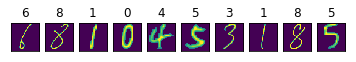

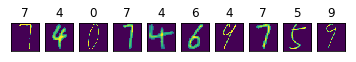

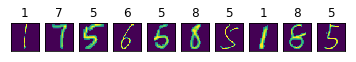

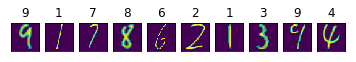

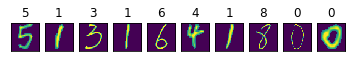

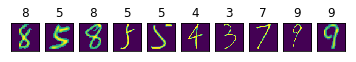

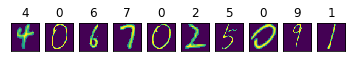

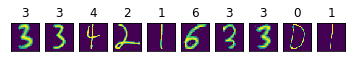

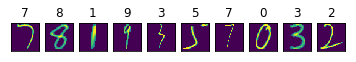

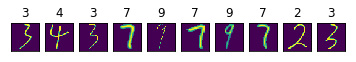

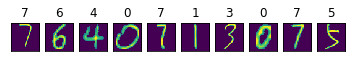

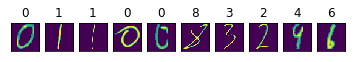

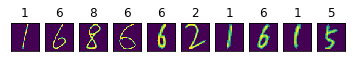

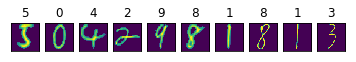

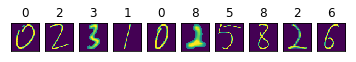

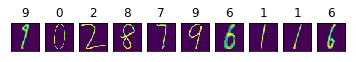

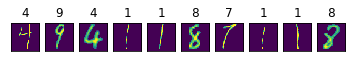

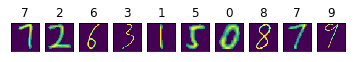

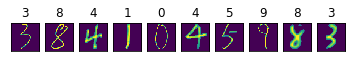

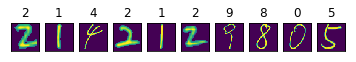

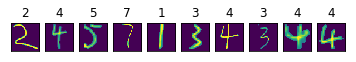

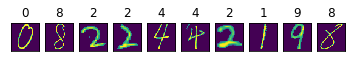

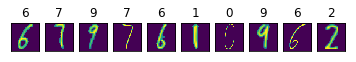

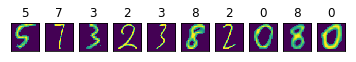

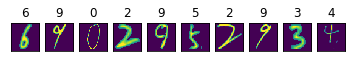

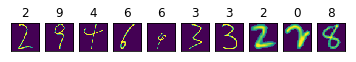

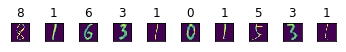

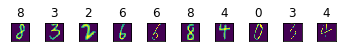

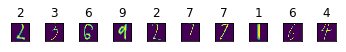

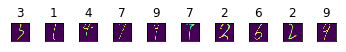

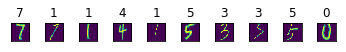

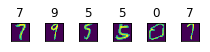

In [261]:
import os
j = 1
l = os.listdir('D:\\pyproj\\wonderful\\data\\nums\\done')
l0 = l[: 50]
l1 = l[50: 100]
l2 = l[100: 150]
l3 = l[150: 200]
l4 = l[200: 250]
l5 = l[250: 300]
l6 = l[300: ]
for i in l0:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

j = 1
for i in l1:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1
    
j = 1
for i in l2:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1
    
j = 1
for i in l3:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1
    
j = 1
for i in l4:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1
    
j = 1
for i in l5:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(5, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

j = 1
for i in l6:
    
    img = cv2.imread(os.path.join('D:\\pyproj\\wonderful\\data\\nums\\done', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
    img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(10, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    
    if j % 10 == 0:
        plt.show()
    j += 1

---

# new test

In [ ]:
path = 'F:\\OCR_SINGLE\\testImages'

In [ ]:
file_list = os.listdir(path)
file_list

In [ ]:
j = 1
l0 = file_list[:100]
for i in l0:
    
    img = cv2.imread(os.path.join(path, i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img < 0.16] = 0.0
#     img[img > 0] += 0.2
    img[img > 1.] = 1.
    sub_img = preprocessing(img)
    
    plt.subplot(10, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
#     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
    if j % 10 == 0:
        plt.show()
    j += 1

In [ ]:
l = []
for i in range(len(file_list)):
    if (i + 1) % 100 == 0:
        l.append(file_list[i - 99: i + 1])

In [ ]:
len(l[0])

In [ ]:
for ll in l:
    j = 1
    for i in ll:
        img = cv2.imread(os.path.join(path, i), cv2.IMREAD_GRAYSCALE)

        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img[img < 0.16] = 0.0
    #     img[img > 0] += 0.2
        img[img > 1.] = 1.
        sub_img = preprocessing(img)

        plt.subplot(10, 10, j)
        plt.imshow(sub_img)
        plt.xticks([])  #去掉横坐标值
        plt.yticks([])  #去掉纵坐标值
        plt.axis = False
        plt.title(np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
    #     print(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
        if j % 10 == 0:
            plt.show()
        j += 1

In [ ]:
path = 'F:\\OCR_SINGLE'
file_list = os.listdir(path)
print(file_list)
nums = []
for i in file_list:
    if str.isdigit(i):
        nums.append(i)
nums

In [ ]:
errors = {}
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)
#         print(os.path.join(path, i, j))
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img[img < 0.16] = 0.0
    #     img[img > 0] += 0.2
        img[img > 1.] = 1.
        sub_img = preprocessing(img)
        
        pred = np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
        
        if not pred == label:
            errors[label] += 1
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))


---

In [ ]:
def chirography_normal(img, wid=2, eps=0, delta=5):
    """

    :param img:
    :return:
    """
    mask = img > 0
    mask = mask.astype(np.int)
    # print(np.min(mask), np.max(mask))
    # plt.imshow(img)
    # plt.title('origin')
    # plt.show()

    maskl = mask[:, :-1]
    maskr = mask[:, 1:]
    masku = mask[1:]
    maskd = mask[: -1]

    horizon_offset = 1 - maskl == maskr
    vertical_offset = 1 - masku == maskd

    final_mask = np.zeros(img.shape)
    masko = np.zeros(img.shape)

    final_mask[: -1] += vertical_offset
    final_mask[:, : -1] += horizon_offset
    final_mask[final_mask > 0] = 1
    # plt.imshow(final_mask)
    # plt.title('final mask')
    # plt.show()

    dist_field = np.zeros(img.shape)

    # plt.imshow(mask)
    # plt.title('mask')
    # plt.show()

    mask[final_mask > 0] = 0
    # plt.imshow(mask)
    # plt.title('mask1')
    # plt.show()

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if final_mask[i, j] <= 0:
                continue
            distance = np.array([1e3, 1e3, 1e3, 1e3])

            r = np.argwhere(mask[i, j + 1:] == 0).reshape(-1, )[0]
            d = np.argwhere(mask[i + 1:, j] == 0).reshape(-1, )[0]
            l = j - np.argwhere(mask[i, : j] == 0).reshape(-1, )[-1]
            u = i - np.argwhere(mask[: i, j] == 0).reshape(-1)[-1]

            if r > eps and np.any(mask[i, j + 1:] > 0) and mask[i, j + 1] > 0:
                distance[0] = r
            if d > eps and np.any(mask[i + 1:, j] > 0) and mask[i + 1, j] > 0:
                distance[1] = d
            if l > eps and np.any(mask[i, : j] > 0) and mask[i, j - 1] > 0:
                distance[2] = l
            if u > eps and np.any(mask[: i, j] > 0) and mask[i - 1, j] > 0:
                distance[3] = u

            x = np.argmin(distance) + 1
            # print(i, j, distance, x)

            if np.min(distance == 1e3):
                # print(i, j, distance, x)
                continue

            dist_field[i, j] = distance[x - 1]
            masko[i, j] = x

            # c = ['green', 'blue', 'red', 'cyan']
            # plt.scatter(j, i, c=c[x - 1])

    # print(np.min(dist_field), np.max(dist_field))
    # plt.imshow(dist_field)
    # plt.title('distance')
    # plt.show()

    for flag in range(1, 5):
        y, x = np.where(masko == flag)
        z = list(zip(y, x))
        # print(z)

        if flag == 1:
            for y, x in z:
                # print(dist_field[y, x] - wid)
                if dist_field[y, x] - wid > delta:
                    mask[y, x: int(x + wid)] = 0
        elif flag == 2:
            for y, x in z:
                if dist_field[y, x] - wid > delta:
                    mask[y: int(y + wid), x] = 0
        elif flag == 3:
            for y, x in z:
                if dist_field[y, x] - wid > delta:
                    mask[y, int(x - wid): x] = 0
        elif flag == 4:
            for y, x in z:
                if dist_field[y, x] - wid > delta:
                    mask[int(y - wid): y, x] = 0

    # plt.imshow(mask)
    # plt.title('result mask')
    # plt.show()

    img1 = img * mask
    img1 = cv2.GaussianBlur(img1, (3, 3), 0)
    img1[img1 < 0.16] = 0
    # plt.imshow(img1)
    # plt.title('result')
    # plt.show()

    return img1

In [ ]:
errors = {}
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)
#         print(os.path.join(path, i, j))
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
        img[img < 0.16] = 0.0
    #     img[img > 0] += 0.2
        img[img > 1.] = 1.
        sub_img = preprocessing(img)
#         plt.imshow(sub_img)
#         plt.title('origin')
#         plt.show()
        sub_img = chirography_normal(sub_img, wid=2, eps=0)
#         plt.imshow(sub_img)
#         plt.title('result')
#         plt.show()
        pred = np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
        
        if not pred == label:
            errors[label] += 1
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))


In [ ]:
errors = {}
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)
#         print(os.path.join(path, i, j))
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
        img[img < 0.16] = 0.0
    #     img[img > 0] += 0.2
        img[img > 1.] = 1.
        sub_img = preprocessing(img)
#         plt.imshow(sub_img)
#         plt.title('origin')
#         plt.show()
        sub_img = chirography_normal(sub_img, wid=0, eps=0)
#         plt.imshow(sub_img)
#         plt.title('result')
#         plt.show()
        pred = np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
        
        if not pred == label:
            errors[label] += 1
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))


In [ ]:
path = 'C:\\Users\\Administrator.WIN-SJ36M83FJQ9\\Music\\84.jpg'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = img / 255
img[img < 0.16] = 0
plt.imshow(img)
plt.show()
print(np.argmax(model.predict(np.expand_dims(np.expand_dims(img, axis=-1), axis=0))))

img = chirography_normal(img, wid=2, eps=0)
plt.imshow(img)
plt.show()
print(np.argmax(model.predict(np.expand_dims(np.expand_dims(img, axis=-1), axis=0))))

In [ ]:
import os
import tensorflow as tf
import keras
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt

path = r'F:\234\character'
file_list = os.listdir(path)
print(file_list)
nums = []
for i in file_list:
    if str.isdigit(i):
        nums.append(i)
nums

In [ ]:
import cv2
import uuid
errors = {}
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
        
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)
#         print(os.path.join(path, i, j))
        try:
            len(img)
        except Exception as e:
            print(j)
            continue
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img[img < 0.16] = 0.0
#         img[img > 0] += 0.2
#         img[img > 1.] = 1.
        sub_img = preprocessing(img)

#         img = cv2.resize(img, (48, 48))
#         plt.imshow(sub_img)
#         plt.show()
        pred = np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
        
        if not pred == label:
            errors[label] += 1
            uid = str(uuid.uuid1())
            if not os.path.exists('f:/345/%s' % i):
                os.mkdir('f:/345/%s' % i)
            fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'o') + '.jpg'
            cv2.imwrite(os.path.join('f:/345/%s' % str(i), fname), cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE))
            fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'r') + '.jpg'
            cv2.imwrite(os.path.join('f:/345/%s' % str(i), fname), sub_img * 255)
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))

In [ ]:
errors = {}
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
        
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)
#         print(os.path.join(path, i, j))
        try:
            len(img)
        except Exception as e:
            print(j)
            continue
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        plt.imshow(img)
        plt.title('ori')
        plt.show()
#         img[img < 0.16] = 0.0
#         img[img > 0] += 0.2
#         img[img > 1.] = 1.
#         sub_img = preprocessing(img)
#         plt.imshow(sub_img)
#         plt.title('ori')
#         plt.show()
#         sub_img = chirography_normal(sub_img, wid=3, eps=0, delta=5)
#         plt.imshow(sub_img)
#         plt.title('chi')
#         plt.show()
#         img[img > 0] += 0.12
#         img[img > 1.] = 1.
        pred = np.argmax(model.predict(np.expand_dims(np.expand_dims(img, axis=-1), axis=0)))
        
        if not pred == label:
            errors[label] += 1
            uid = str(uuid.uuid1())
            if not os.path.exists('f:/456/%s' % i):
                os.mkdir('f:/456/%s' % i)
            fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'o') + '.jpg'
            cv2.imwrite(os.path.join('f:/456/%s' % str(i), fname), cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE))
            fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'r') + '.jpg'
            cv2.imwrite(os.path.join('f:/456/%s' % str(i), fname), sub_img * 255)
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))

---

In [4]:
from keras.models import *
model = load_model('cnn3_gen_1.3_ftn.h5')

In [6]:
path = r'F:\hand_writing\nums'
file_list = os.listdir(path)
print(file_list)
nums = []
for i in file_list:
    if str.isdigit(i):
        nums.append(i)
nums
errors = {}
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
        
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)

        img = img / 255.0
        sub_img = img
        
        pred = np.argmax(model.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
        
#         if not pred == label:
#             errors[label] += 1
#             uid = str(uuid.uuid1())
#             if not os.path.exists('f:/567/%s' % i):
#                 os.mkdir('f:/567/%s' % i)
#             fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'r') + '.jpg'
#             cv2.imwrite(os.path.join('f:/567/%s' % str(i), fname), sub_img * 255)
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0


In [1]:
from keras.models import *
nmodel = load_model('cnn3_gen_1.2.h5')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
import cv2
import numpy as np
path = r'F:\hand_writing\nums'
file_list = os.listdir(path)
print(file_list)
nums = []
for i in file_list:
    if str.isdigit(i):
        nums.append(i)
        
errors = {}
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
        
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)
        
#         print(os.path.join(path, i, j))
#         try:
#             len(img)
#         except Exception as e:
#             print(j)
#             continue
#         img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = img / 255.0
        sub_img = img

#         img[img < 0.16] = 0.0
# #         img[img > 0] += 0.2
# #         img[img > 1.] = 1.
#         sub_img = preprocessing(img)

#         sub_img = chirography_normal(sub_img, wid=3, eps=0, delta=5)
        
        pred = np.argmax(nmodel.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
#         plt.imshow(sub_img)
#         plt.title('%s--%s' % (str(label), str(pred)))
#         plt.show()
        
        if not pred == label:
            errors[label] += 1
#             uid = str(uuid.uuid1())
#             if not os.path.exists('f:/456/%s' % i):
#                 os.mkdir('f:/456/%s' % i)
#             fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'o') + '.jpg'
#             cv2.imwrite(os.path.join('f:/456/%s' % str(i), fname), cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE))
#             fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'r') + '.jpg'
#             cv2.imwrite(os.path.join('f:/456/%s' % str(i), fname), sub_img * 255)
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
0 0.9777777777777777
1 0.993421052631579
2 0.9849624060150376
3 0.9722222222222222
4 1.0
5 1.0
6 0.967391304347826
7 0.9375
8 0.9888888888888889
9 0.9555555555555556


In [15]:
omodel = load_model('cnn3_gen_gpu_1.5.h5')

In [16]:
errors = {}
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
        
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)
        
#         print(os.path.join(path, i, j))
#         try:
#             len(img)
#         except Exception as e:
#             print(j)
#             continue
#         img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = img / 255.0
        sub_img = img

#         img[img < 0.16] = 0.0
# #         img[img > 0] += 0.2
# #         img[img > 1.] = 1.
#         sub_img = preprocessing(img)

#         sub_img = chirography_normal(sub_img, wid=3, eps=0, delta=5)
        
        pred = np.argmax(omodel.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0)))
#         plt.imshow(sub_img)
#         plt.title('%s--%s' % (str(label), str(pred)))
#         plt.show()
        
#         if not pred == label:
#             errors[label] += 1
#             uid = str(uuid.uuid1())
#             if not os.path.exists('f:/456/%s' % i):
#                 os.mkdir('f:/456/%s' % i)
#             fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'o') + '.jpg'
#             cv2.imwrite(os.path.join('f:/456/%s' % str(i), fname), cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE))
#             fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'r') + '.jpg'
#             cv2.imwrite(os.path.join('f:/456/%s' % str(i), fname), sub_img * 255)
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))

0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0


In [217]:
from sklearn.externals import joblib
svc = joblib.load('ocr_svm_1.0.0.m')

In [218]:
errors = {}
print(path)
for i in nums:
    label = int(i)
    errors[label] = 0
    for j in os.listdir(os.path.join(path, i)):
        
#         print(print(os.path.join(path, i, j)))
        img = cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE)
        
#         print(os.path.join(path, i, j))
#         try:
#             len(img)
#         except Exception as e:
#             print(j)
#             continue
#         img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = img / 255.0
        sub_img = img

#         img[img < 0.16] = 0.0
# #         img[img > 0] += 0.2
# #         img[img > 1.] = 1.
#         sub_img = preprocessing(img)

#         sub_img = chirography_normal(sub_img, wid=3, eps=0, delta=5)
        img = img.reshape(1, -1)
        pred = svc.predict(img)
#         plt.imshow(sub_img)
#         plt.title('%s--%s' % (str(label), str(pred)))
#         plt.show()
#         print(pred)
        if not pred == label:
            errors[label] += 1
#             uid = str(uuid.uuid1())
#             if not os.path.exists('f:/456/%s' % i):
#                 os.mkdir('f:/456/%s' % i)
#             fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'o') + '.jpg'
#             cv2.imwrite(os.path.join('f:/456/%s' % str(i), fname), cv2.imread(os.path.join(path, i, j), cv2.IMREAD_GRAYSCALE))
#             fname = '%s-%s-%s-%s-' % (uid, str(pred), str(label), 'r') + '.jpg'
#             cv2.imwrite(os.path.join('f:/456/%s' % str(i), fname), sub_img * 255)
    print(label, 1 - errors[label] / len(os.listdir(os.path.join(path, i))))

F:\234\character
0 0.9581993569131833
1 0.10859728506787325
2 0.9626352015732547
3 0.9745493107104984
4 0.9874125874125874
5 0.9292452830188679
6 0.9828571428571429
7 0.9878787878787879
8 0.9523269012485811
9 0.8677932405566601


In [ ]:
model = load_model('cnn3_gen.h5')

In [198]:
nmodel = load_model('cnn3_gen_1.3_ftn.h5')

In [7]:
p = r'C:\Users\Administrator.WIN-SJ36M83FJQ9\Music\pred'
# p = r'F:\num_ocr\1'
p

'C:\\Users\\Administrator.WIN-SJ36M83FJQ9\\Music\\pred'

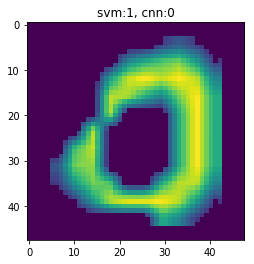

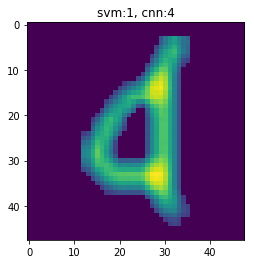

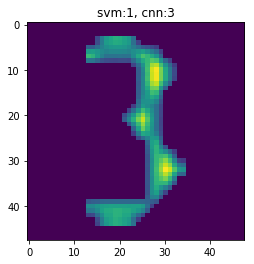

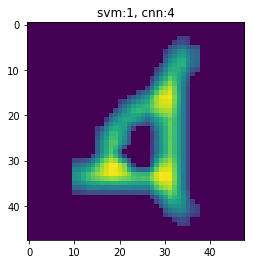

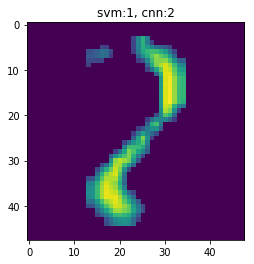

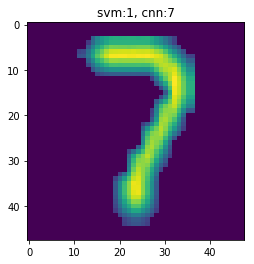

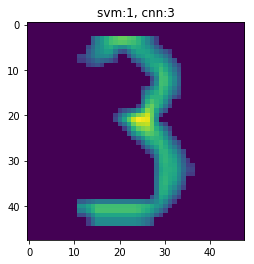

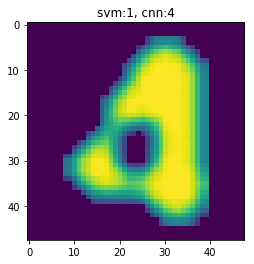

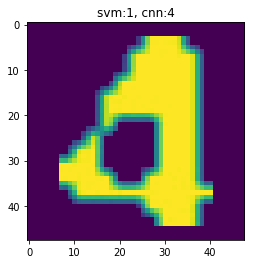

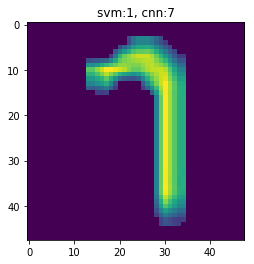

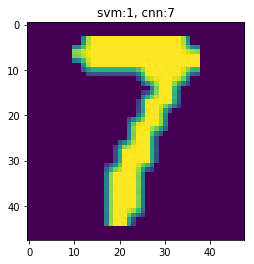

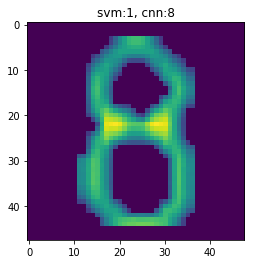

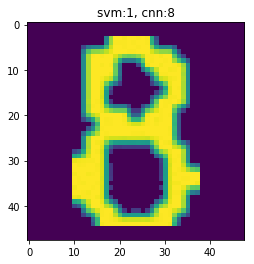

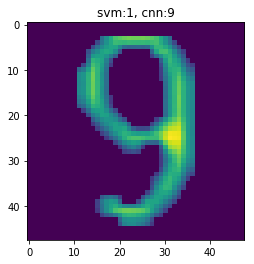

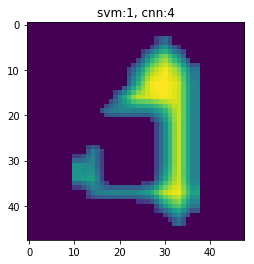

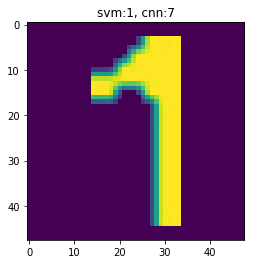

In [12]:
import matplotlib.pyplot as plt
for fname in os.listdir(p):
    img = cv2.imread(os.path.join(p, fname), cv2.IMREAD_GRAYSCALE)
    img = img / 255.
    img[img < 0.16] = 0
    pred = np.argmax(nmodel.predict(np.expand_dims(np.expand_dims(img, axis=-1), axis=0)))
#     pred1 = svc.predict(img.reshape(1, -1))
    plt.title('svm:%s, cnn:%s' % (1, pred))
    plt.imshow(img)
    plt.show()

9
[8]


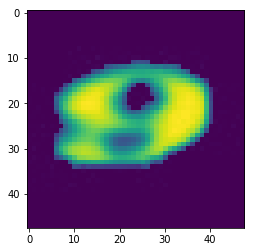

In [206]:
print(np.argmax(nmodel.predict(np.expand_dims(np.expand_dims(sub_img, axis=-1), axis=0))))
print(svc.predict(sub_img.reshape(1, -1)))
plt.imshow(sub_img)

In [229]:
path = r'F:/num_ocr'
file_list = os.listdir(path)
print(file_list)
nums = []

for i in file_list:
    if str.isdigit(i):
        nums.append(i)
nums
l = []
for i in nums:
    label = int(i)
    ll = []
    for j in os.listdir(os.path.join(path, i)):
        ll.append(label)
    l.append(ll)
len(l)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


10

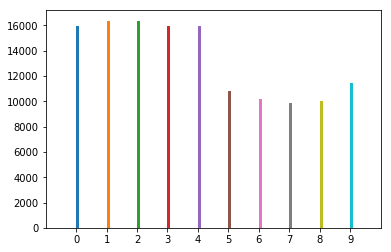

In [228]:
my_x_ticks = np.arange(0, 10, 1)
plt.xticks(my_x_ticks)
for i in l:
    plt.hist(i)

In [224]:
 np.arange(0, 10, 1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


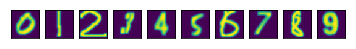

0

In [254]:
path = r'F:/dialate_ocr1/'
file_list = os.listdir(path)
print(file_list)
nums = []

for i in file_list:
    if str.isdigit(i):
        nums.append(i)

import random as rd
l = []

# plt.figure(figsize=(8, 6)) 
for i in nums:
    label = int(i)
#     print(os.listdir(os.path.join(path, i)))
#     print(os.path.join(path, i, os.listdir(os.path.join(path, i))[rd.randint(100, 200)]))
    img = cv2.imread(os.path.join(path, i, os.listdir(os.path.join(path, i))[rd.randint(1100, 5200)]), cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(1, 10, label + 1)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.imshow(img / 255.)
plt.show()
len(l)

In [ ]:
plt.xticks([])  #去掉横坐标值
plt.yticks([])  #去掉纵坐标值
plt.axis = False